In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv


In [4]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from nltk.tokenize import word_tokenize

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()
import warnings
warnings.filterwarnings('ignore')

In [153]:
df = pd.read_csv("/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv")

In [154]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [155]:
df.shape

(47692, 2)

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [157]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})
df.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [158]:
df.duplicated().sum()

36

In [159]:
df.drop_duplicates(inplace=True)

In [160]:
df.sentiment.value_counts()

sentiment
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

# Text Cleaning

In [161]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.get_emoji_regexp().sub("", text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    #tweet = strip_emoji(tweet)
    #tweet = expand_contractions(tweet) #install and do it seperately
    #tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    #tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [162]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [163]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,words katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks heads concerned another angry dude ...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isis account pretending kurdish account like i...


In [164]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 4395 duplicated tweets, we will remove them.


In [165]:
df.drop_duplicates("text_clean", inplace=True)

In [166]:
df.sentiment.value_counts()

sentiment
religion               7946
age                    7879
ethnicity              7759
gender                 7465
not_cyberbullying      6983
other_cyberbullying    5229
Name: count, dtype: int64

In [167]:
df = df[df["sentiment"]!="other_cyberbullying"]

In [168]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

In [169]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

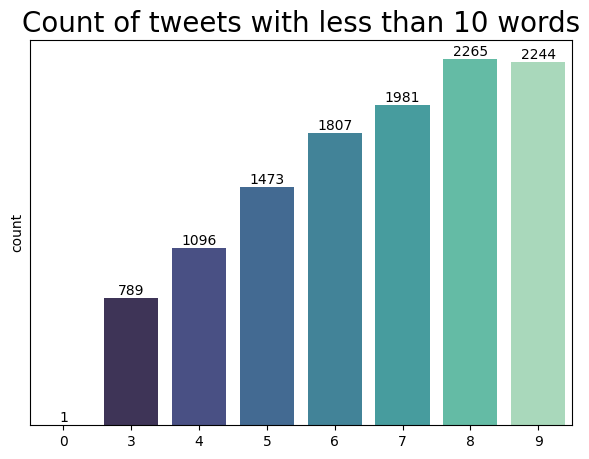

In [170]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [171]:
df.text_len.value_counts().sort_index() #can also remove text_len=0

text_len
0         1
3       789
4      1096
5      1473
6      1807
7      1981
8      2265
9      2244
10     2273
11     2280
12     2200
13     2047
14     1813
15     1498
16     1192
17      954
18      872
19      832
20      821
21      833
22      994
23     1112
24     1158
25     1095
26     1012
27      946
28      750
29      594
30      414
31      271
32      175
33      102
34       58
35       28
36       14
37        7
38        6
39        7
40        4
41        1
42        1
43        1
73        1
86        1
104       1
115       1
123       1
124       2
139       1
146       1
158       1
182       1
Name: count, dtype: int64

In [172]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

In [173]:
max_len = np.max(df['text_len'])
max_len 

32

In [174]:
df.text_len.value_counts().sort_index() #can also remove text_len=0

text_len
0        1
3      789
4     1096
5     1473
6     1807
7     1981
8     2265
9     2244
10    2273
11    2280
12    2200
13    2047
14    1813
15    1498
16    1192
17     954
18     872
19     832
20     821
21     833
22     994
23    1112
24    1158
25    1095
26    1012
27     946
28     750
29     594
30     414
31     271
32     175
Name: count, dtype: int64

In [175]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
8422,"Calling a female colleague a ""fucking bitch"" i...",gender,calling female colleague fucking bitch treatin...,32
38500,RULES TO TEACH YOUR KIDS: Never shake a hand s...,age,rules teach kids never shake hand sitting dont...,32
9738,"Let's see, @CNN said that President Trump's pu...",gender,lets see said president trumps put nazis cabin...,32
21427,Only Far Right Radical Republicans (Cherry Pic...,religion,far right radical republicans cherry picking c...,32
42382,(Acts 29:22531) SINCE the white people DO NOT ...,ethnicity,acts since white people look way god looks div...,32
...,...,...,...,...
5507,it is what it is tho i do understand how they ...,not_cyberbullying,tho understand feel,3
986,Watching #MKR before @marlo_music LEL @Jordana...,not_cyberbullying,watching mkr lel,3
35063,it was the name of his school bully!,age,name school bully,3
20363,@dankmtl what they tell you is their intention...,religion,tell intention intention,3


In [176]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

In [177]:
df.head()

,text,sentiment,text_clean,text_len
0,"In other words #katandandre, your food was cra...",4,words katandandre food crapilicious mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,4,aussietv white mkr theblock imacelebrityau tod...,11
2,@XochitlSuckkks a classy whore? Or more red ve...,4,classy whore red velvet cupcakes,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",4,meh thanks heads concerned another angry dude ...,8
4,@RudhoeEnglish This is an ISIS account pretend...,4,isis account pretending kurdish account like i...,8


In [178]:
X = df['text_clean']
y = df['sentiment']

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [180]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6302],
       [   1, 6268],
       [   2, 6150],
       [   3, 5929],
       [   4, 5584]])

In [181]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [182]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [183]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6302],
       [   1, 6302],
       [   2, 6302],
       [   3, 6302],
       [   4, 6302]])

# NLP Machine Learning

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),    
     ('KNN', KNeighborsClassifier())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1550
           1       0.83      0.89      0.85      1542
           2       0.81      0.93      0.87      1519
           3       0.82      0.80      0.81      1463
           4       0.70      0.57      0.63      1396

    accuracy                           0.81      7470
   macro avg       0.80      0.80      0.80      7470
weighted avg       0.80      0.81      0.80      7470



In [61]:
from sklearn.naive_bayes import MultinomialNB


#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),    
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1550
           1       0.79      0.98      0.88      1542
           2       0.90      0.94      0.92      1519
           3       0.86      0.85      0.86      1463
           4       0.84      0.45      0.59      1396

    accuracy                           0.84      7470
   macro avg       0.85      0.84      0.83      7470
weighted avg       0.85      0.84      0.83      7470



In [62]:
from sklearn.ensemble import RandomForestClassifier

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),        #using the ngram_range parameter 
     ('Random Forest', RandomForestClassifier())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1550
           1       0.97      0.98      0.97      1542
           2       0.99      0.99      0.99      1519
           3       0.95      0.84      0.89      1463
           4       0.79      0.88      0.83      1396

    accuracy                           0.93      7470
   macro avg       0.93      0.93      0.93      7470
weighted avg       0.93      0.93      0.93      7470



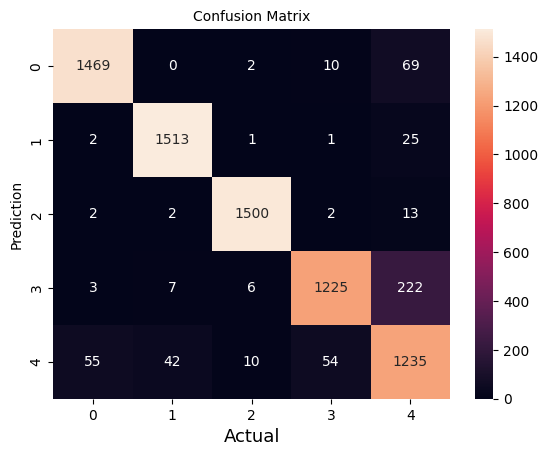

In [63]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
#             xticklabels=['religion','age','ethnicity','gender','not_cyberbullying'],
#             yticklabels=['religion','age','ethnicity','gender','not_cyberbullying'],
           )
plt.ylabel('Prediction',fontsize=10)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=10)
plt.show()

In [64]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 1))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      1550
           1       0.81      0.99      0.89      1542
           2       0.91      0.96      0.93      1519
           3       0.87      0.84      0.86      1463
           4       0.83      0.48      0.61      1396

    accuracy                           0.86      7470
   macro avg       0.86      0.85      0.84      7470
weighted avg       0.86      0.86      0.84      7470



In [65]:
from sklearn.ensemble import RandomForestClassifier

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 1))),        #using the ngram_range parameter 
     ('Multi NB', RandomForestClassifier())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1550
           1       0.98      0.98      0.98      1542
           2       0.99      0.99      0.99      1519
           3       0.95      0.86      0.90      1463
           4       0.80      0.89      0.84      1396

    accuracy                           0.93      7470
   macro avg       0.94      0.93      0.93      7470
weighted avg       0.94      0.93      0.94      7470



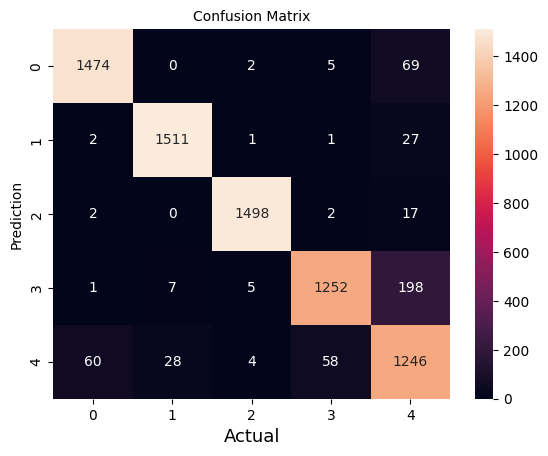

In [66]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
#             xticklabels=['religion','age','ethnicity','gender','not_cyberbullying'],
#             yticklabels=['religion','age','ethnicity','gender','not_cyberbullying'],
           )
plt.ylabel('Prediction',fontsize=10)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=10)
plt.show()

# NLP DL

In [184]:
df.head()

,text,sentiment,text_clean,text_len
0,"In other words #katandandre, your food was cra...",4,words katandandre food crapilicious mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,4,aussietv white mkr theblock imacelebrityau tod...,11
2,@XochitlSuckkks a classy whore? Or more red ve...,4,classy whore red velvet cupcakes,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",4,meh thanks heads concerned another angry dude ...,8
4,@RudhoeEnglish This is an ISIS account pretend...,4,isis account pretending kurdish account like i...,8


In [185]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

In [186]:
len(vocabulary)

43563

In [187]:
print(vocabulary,end=" ")

[('school', 8508), ('fuck', 5449), ('like', 5266), ('dumb', 5109), ('high', 4972), ('bullied', 4395), ('people', 4292), ('nigger', 4142), ('rape', 4013), ('dont', 3839), ('gay', 3775), ('im', 3656), ('jokes', 3338), ('rt', 3317), ('one', 3073), ('bully', 3025), ('girls', 2757), ('girl', 2622), ('black', 2611), ('ass', 2560), ('get', 2428), ('muslims', 2392), ('muslim', 2311), ('mkr', 2290), ('amp', 2275), ('white', 2080), ('know', 2023), ('bitch', 1897), ('joke', 1849), ('think', 1837), ('would', 1816), ('idiot', 1794), ('right', 1691), ('say', 1589), ('bullies', 1571), ('call', 1564), ('christian', 1506), ('got', 1477), ('even', 1468), ('go', 1431), ('women', 1423), ('make', 1422), ('cant', 1416), ('called', 1404), ('woman', 1385), ('ur', 1376), ('idiots', 1372), ('youre', 1364), ('never', 1361), ('shit', 1357), ('see', 1333), ('fucking', 1268), ('islam', 1253), ('niggers', 1251), ('still', 1248), ('time', 1247), ('first', 1237), ('islamic', 1234), ('really', 1232), ('want', 1218), ('

In [188]:
df["text_clean"].iloc[0], tokenized_column[0]

('words katandandre food crapilicious mkr',
 array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
          314,  2106,   616, 18260,    24]))

In [189]:
df["text_clean"].iloc[30], tokenized_column[30]

('thing uber even wasnt horrible sexist shitty company would still',
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         109, 4919,   39,  228,  662,   73,  915, 1544,   31,   55]))

# Word2vec

In [190]:
X_train

array(['fucking moron slavery approved right quran read stupid idiot',
       'rt angry cartoons beheadings people burnt alive',
       'hating classic like laffy taffy mean lol', ...,
       'im still unsure really want feeling little pants money dude money dunno',
       'lol still hoppin around shit lol',
       'rt muslim condemnation atrocities silence deafening'],
      dtype=object)

In [191]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train)) # breaks every sentence into words

In [192]:
Word2vec_train_data

[['fucking',
  'moron',
  'slavery',
  'approved',
  'right',
  'quran',
  'read',
  'stupid',
  'idiot'],
 ['rt', 'angry', 'cartoons', 'beheadings', 'people', 'burnt', 'alive'],
 ['hating', 'classic', 'like', 'laffy', 'taffy', 'mean', 'lol'],
 ['bully', 'weekend', 'get', 'away', 'lmao', 'rise'],
 ['forgive',
  'high',
  'school',
  'bully',
  'say',
  'sorry',
  'youve',
  'wronged',
  'product',
  'time',
  'youve',
  'changed',
  'better'],
 ['holy', 'fuck', 'youre', 'dumb', 'nigger'],
 ['black',
  'bodies',
  'white',
  'heads',
  'called',
  'every',
  'one',
  'negro',
  'progress',
  'organizations',
  'composition',
  'black',
  'leaders',
  'public',
  'eye',
  'seen'],
 ['female',
  'engineers',
  'make',
  'comp',
  'male',
  'engineers',
  'without',
  'specific',
  'professional',
  'comparisons',
  'info',
  'useless'],
 ['rt',
  'im',
  'sexist',
  'hate',
  'certain',
  'girls',
  'tweet',
  'football',
  'bet',
  'think',
  'offside',
  'seasoning'],
 ['whats',
  'poin

In [193]:
EMBEDDING_DIM = 200 # each word in 200 dimensions vectorspace


In [135]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [136]:
word2vec_model

In [137]:
print(f"Vocabulary size: {len(word2vec_model.wv.key_to_index)}")

Vocabulary size: 7710


In [138]:
word = 'supports'  # each word in 200 vector space
if word in word2vec_model.wv:
    print(word2vec_model.wv[word])
else:
    print(f"'{word}' is not in the vocabulary")


[-0.05837203 -0.06607459  0.01791641  0.15689068  0.13109107  0.04383015
 -0.06060942  0.30816954 -0.0920798   0.12180571 -0.25429997 -0.07758479
 -0.09326442 -0.16815512 -0.16070873 -0.14340422  0.00075294 -0.0528034
  0.05392912 -0.06370112  0.11028782 -0.2607577  -0.19479467  0.17152515
  0.04593093 -0.12860309 -0.08350895 -0.06575464 -0.2857067   0.10870139
  0.18486023  0.15144134 -0.1872543   0.02078635  0.14654975  0.11002769
  0.31750667 -0.08625089 -0.06659845 -0.34400198 -0.1654883  -0.19964667
  0.06251303  0.11696246  0.07133853 -0.13780807  0.00660064  0.03548446
  0.09198222  0.07878781  0.1771359   0.03557984  0.09068949 -0.04361759
 -0.10697364  0.20358509 -0.0830035  -0.01273489 -0.20602529  0.07074577
 -0.00142777  0.31015298 -0.11144674 -0.25166276 -0.06709221 -0.00678306
 -0.04852999  0.29530334  0.05411359  0.18887678 -0.10314003  0.00651479
  0.07319856 -0.12930217  0.07809513  0.14117102 -0.18236989 -0.07106869
 -0.18568812 -0.04054768 -0.25445902 -0.02282822 -0.

In [139]:
similar_words = word2vec_model.wv.most_similar('example', topn=10)  # Replace 'example' with your word of interest
for word, similarity in similar_words:
    print(f"{word}: {similarity}")


oppose: 0.9946397542953491
christianity: 0.9906629920005798
agenda: 0.9895179867744446
buddhist: 0.9867291450500488
minority: 0.9859657287597656
evil: 0.98572838306427
leftists: 0.9846290946006775
communist: 0.9840709567070007
protects: 0.9838557839393616
extremist: 0.98355633020401


In [194]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 43564


In [115]:
vocabularys = list(word2vec_model.wv.key_to_index.keys())
print(vocabularys)


['school', 'fuck', 'like', 'dumb', 'high', 'bullied', 'rape', 'nigger', 'people', 'gay', 'dont', 'im', 'jokes', 'rt', 'bully', 'one', 'girls', 'ass', 'girl', 'black', 'mkr', 'get', 'muslims', 'muslim', 'amp', 'white', 'know', 'joke', 'bitch', 'would', 'think', 'idiot', 'right', 'say', 'call', 'bullies', 'christian', 'got', 'women', 'make', 'go', 'shit', 'even', 'cant', 'called', 'woman', 'idiots', 'youre', 'see', 'never', 'ur', 'fucking', 'niggers', 'really', 'thats', 'want', 'obama', 'time', 'islamic', 'islam', 'said', 'first', 'still', 'support', 'us', 'anything', 'also', 'man', 'hate', 'terrorism', 'bullying', 'good', 'sexist', 'radical', 'way', 'back', 'didnt', 'men', 'racist', 'made', 'love', 'stop', 'female', 'need', 'lol', 'funny', 'every', 'doesnt', 'mean', 'middle', 'going', 'much', 'someone', 'racism', 'past', 'look', 'years', 'world', 'bad', 'isis', 'always', 'saying', 'many', 'terrorist', 'well', 'yall', 'thing', 'life', 'making', 'day', 'take', 'kids', 'hes', 'friends', 'n

# Using here custom tokenize library

In [199]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding
VOCAB_SIZE

43564

In [200]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (43564, 200)


In [201]:
X = tokenized_column
y = df['sentiment'].values

In [202]:
X[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
         314,  2106,   616, 18260,    24])

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [204]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6302],
       [   1, 6268],
       [   2, 6150],
       [   3, 5929],
       [   4, 5584]])

In [205]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [206]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6302],
       [   1, 6302],
       [   2, 6302],
       [   3, 6302],
       [   4, 6302]])

In [207]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [208]:
BATCH_SIZE = 32

In [209]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)


# LSTM Model

In [210]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        attn_weights = self.v(attn_weights).squeeze(2)
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        self.attention = Attention(hidden_dim, is_bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        out, hidden = self.lstm(embedded, hidden)
        attn_weights = self.attention(hidden[0], out)
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        factor = 2 if self.is_bidirectional else 1
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        hidden = (h0,c0)
        return hidden

In [211]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

IS_BIDIRECTIONAL = False # Set this to False for unidirectional LSTM, and True for bidirectional LSTM

LR = 4e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
EPOCHS = 10 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)

model = model.to(DEVICE)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
# Allow the embedding matrix to be fine-tuned to better adapt to our dataset and get higher accuracy
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(43564, 200)
  (lstm): LSTM(200, 100, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [212]:
torch.cuda.get_device_name(0) # Get name device with ID '0'

'Tesla P100-PCIE-16GB'

In [213]:
total_step = len(train_loader)
total_step_val = len(test_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 92.280191).  Saving model ...
	Train_loss : 0.5776 Val_loss : 0.2253
	Train_acc : 78.646% Val_acc : 92.280%
Epoch 2:Validation accuracy increased (92.280191 --> 92.783369).  Saving model ...
	Train_loss : 0.1610 Val_loss : 0.2046
	Train_acc : 94.623% Val_acc : 92.783%
Epoch 3:Validation accuracy did not increase
	Train_loss : 0.0934 Val_loss : 0.2298
	Train_acc : 97.015% Val_acc : 92.386%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0557 Val_loss : 0.2478
	Train_acc : 98.310% Val_acc : 92.598%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0351 Val_loss : 0.2674
	Train_acc : 98.981% Val_acc : 92.360%
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.0285 Val_loss : 0.2960
	Train_acc : 99.130% Val_acc : 92.346%
Epoch 7:Validation accuracy did not increase
Early stopped at epoch : 7


# Transfer Learning Bert

In [229]:
X = df['text_clean'].values
y = df['sentiment'].values

In [215]:
X,y

(array(['words katandandre food crapilicious mkr',
        'aussietv white mkr theblock imacelebrityau today sunrise studio neighbours wonderlandten etc',
        'classy whore red velvet cupcakes', ...,
        'swear god dumb nigger bitch got bleach hair reeeal fuckin soon dlt fuck',
        'yea fuck rt youre nigger fucking unfollow fucking dumb niggers',
        'bro gotta chill rt dog fuck kp dumb nigger bitch lmao'],
       dtype=object),
 array([4, 4, 4, ..., 2, 2, 2]))

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [217]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [218]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [219]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [220]:
X_train_os

array(['sure yet ive heard good things many people',
       'fuck obama dumb ass nigger look bitch keep throwing word suck nigga dick fat honkey',
       'school yard bully lying sales picking fights showing hes shit ages',
       ..., 'yo check helped much eyestrain',
       'lrt stuck head since bauer piece floating around would definitely like convo louder',
       'gross feeling urge shower boiling water'], dtype=object)

In [221]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5042],
       [   1, 5042],
       [   2, 5042],
       [   3, 5042],
       [   4, 5042]])

In [222]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # download tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [121]:
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [224]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [225]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  82


In [226]:
encoded_tweets

[[101, 2469, 2664, 4921, 2063, 2657, 2204, 2477, 2116, 2111, 102],
 [101,
  6616,
  8112,
  12873,
  4632,
  9152,
  13327,
  2298,
  7743,
  2562,
  6886,
  2773,
  11891,
  9152,
  23033,
  5980,
  6638,
  10189,
  14839,
  102],
 [101,
  2082,
  4220,
  20716,
  4688,
  4341,
  8130,
  9590,
  4760,
  2002,
  2015,
  4485,
  5535,
  102],
 [101,
  23973,
  20930,
  2825,
  2300,
  4654,
  21710,
  3064,
  2066,
  4689,
  2627,
  2781,
  2130,
  16644,
  11865,
  2671,
  102],
 [101, 6570, 4028, 9040, 21877, 3527, 21850, 6632, 2092, 102],
 [101, 2064, 2102, 17177, 3710, 102],
 [101,
  2113,
  2066,
  2051,
  12043,
  2015,
  3642,
  2412,
  19721,
  7108,
  14556,
  2412,
  102],
 [101, 23637, 12168, 4455, 2308, 5236, 102],
 [101,
  19424,
  4317,
  2304,
  2450,
  7392,
  12501,
  16031,
  3762,
  2559,
  1059,
  2860,
  9200,
  4632,
  2397,
  2606,
  12690,
  4214,
  9152,
  13327,
  2941,
  7494,
  7861,
  14978,
  13970,
  12269,
  102],
 [101,
  2123,
  2102,
  3305,
  5254,
  

In [227]:
MAX_LEN = 128# size of vector

In [238]:
X_test,X_train_os

(array(['baghdadi bad mouthing mullah omar end',
        'joke aidsbeing gayrape ill cut ur face machete right',
        'need skype verification keybaseio', ...,
        'tired bullying sign twition taken away many lives needs stop stopbullying stopcyberbullying',
        'fuck bitch ass niggers doin im touche im nonsense go stupid go dumb like stuges uh',
        'wish send many similar pics army living hell went straight thereif capable ruling hindustan ruled muslims years idiot'],
       dtype=object),
 array(['sure yet ive heard good things many people',
        'fuck obama dumb ass nigger look bitch keep throwing word suck nigga dick fat honkey',
        'school yard bully lying sales picking fights showing hes shit ages',
        ..., 'yo check helped much eyestrain',
        'lrt stuck head since bauer piece floating around would definitely like convo louder',
        'gross feeling urge shower boiling water'], dtype=object))

In [231]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [239]:
train_inputs[0], train_masks[0],test_inputs[0], test_masks[0]

(tensor([ 101, 2469, 2664, 4921, 2063, 2657, 2204, 2477, 2116, 2111,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [230]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

In [240]:
train_labels

tensor([4, 2, 1,  ..., 4, 4, 4])

In [242]:
batch_size = 32

In [246]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [269]:
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [270]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)

    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [271]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

In [272]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

In [273]:
optimizer, scheduler

(AdamW (
 Parameter Group 0
     betas: (0.9, 0.999)
     correct_bias: True
     eps: 1e-08
     initial_lr: 5e-05
     lr: 5e-05
     weight_decay: 0.0
 ),
 <torch.optim.lr_scheduler.LambdaLR at 0x783918759840>)

In [274]:
bert_classifier

Bert_Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")
    
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   1.583724   |   11.45  
   200    |   1.511140   |   11.32  
   300    |   1.434184   |   11.32  
   400    |   1.356370   |   11.35  
   500    |   1.303435   |   11.37  
   600    |   1.250645   |   11.39  
   700    |   1.190824   |   11.39  
   787    |   1.146501   |   9.90   
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   1.350713    |  1.063117  |       76.42       |  109.88  
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   1.109308   |   11.49  
   200    |   1.090494   |   11.36  
   3

In [135]:
def bert_predict(model, test_dataloader):
    
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

In [136]:
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [137]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

    religion       0.94      0.98      0.96      1567
         age       0.99      0.98      0.98      1556
   ethnicity       0.99      0.99      0.99      1475
      gender       0.92      0.91      0.91      1449
not bullying       0.85      0.82      0.84      1213

    accuracy                           0.94      7260
   macro avg       0.94      0.94      0.94      7260
weighted avg       0.94      0.94      0.94      7260



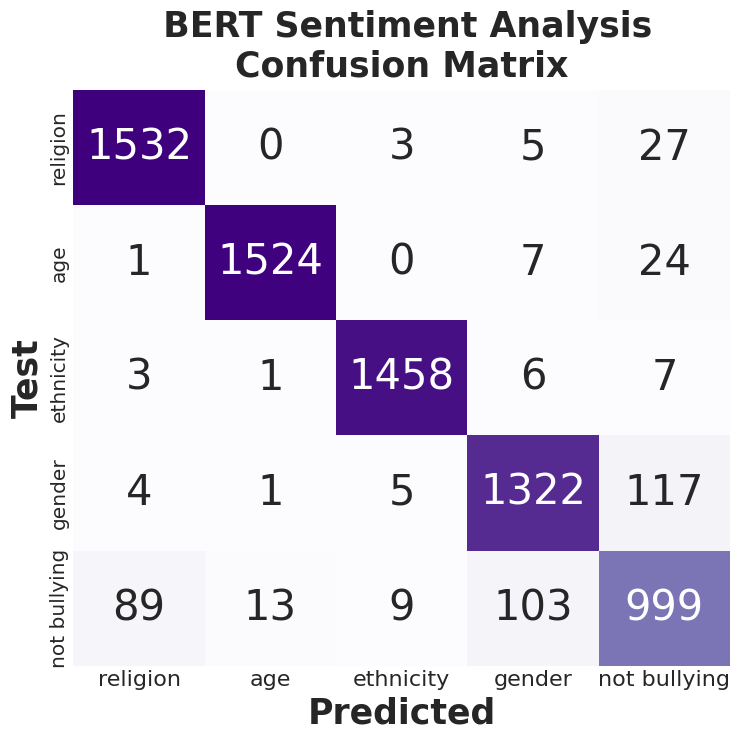

In [141]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)